In [1]:
import ast
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer



In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

### Loading and Preprocessing the Movie Dataset

The necessary datasets are loaded from CSV files to facilitate the development of a movie recommender system. The following steps are performed:

- The datasets containing movie metadata, keywords, credits, ratings, and links are read into separate DataFrames.
- The `id` column in the `movies_df`, `credits_df`, and `keywords_df` DataFrames is converted to a numeric format, ensuring consistency.
- Missing values in the `id` column are dropped to maintain data integrity.
- The `credits_df` and `keywords_df` DataFrames are merged with `movies_df` using a left join on the `id` column to consolidate relevant information.

In [4]:
movies_df = pd.read_csv("movies_metadata.csv", low_memory=False)
keywords_df = pd.read_csv("keywords.csv")
credits_df = pd.read_csv("credits.csv")
ratings_small_df = pd.read_csv("ratings_small.csv")
links_small_df = pd.read_csv("links_small.csv")

movies_df["id"] = pd.to_numeric(movies_df["id"], errors="coerce")
credits_df["id"] = pd.to_numeric(credits_df["id"], errors="coerce")
keywords_df["id"] = pd.to_numeric(keywords_df["id"], errors="coerce")

movies_df.dropna(subset=["id"], inplace=True)
credits_df.dropna(subset=["id"], inplace=True)
keywords_df.dropna(subset=["id"], inplace=True)

movies_df = movies_df.merge(credits_df, on="id", how="left")
movies_df = movies_df.merge(keywords_df, on="id", how="left")

### Parsing and Processing Movie Features

To extract meaningful information from the dataset, various preprocessing steps are applied:

- A function `parse_json(x)` is defined to safely convert JSON-like strings into Python objects using `ast.literal_eval()`. If parsing fails, an empty list is returned.
- The `get_director(crew_list)` function extracts the director's name from the `crew` list, returning `NaN` if no director is found.
- The `get_top_cast(cast_list, top_n=3)` function retrieves the names of the top `n` cast members (defaulting to three).
- The `parse_genres(genres_str)` function extracts genre names from the `genres` field, returning an empty list in case of errors.
- The `create_soup(row)` function constructs a textual representation of key features by combining the director's name, top cast members, genres, and keywords into a single string.
- The `keywords`, `cast`, and `crew` columns are parsed into Python objects using the `parse_json()` function.
- The `director`, `top_cast`, and `genres` columns are extracted using their respective functions.
- A new column, `soup`, is generated by applying the `create_soup()` function to each row, creating a unified text representation of the movie's key attributes.

In [6]:
def parse_json(x):
    try:
        return ast.literal_eval(x)
    
    except:
        return []

def get_director(crew_list):
    for member in crew_list:
        if member.get("job") == "Director":
            return member.get("name")
        
    return np.nan

def get_top_cast(cast_list, top_n=3):
    names = [c.get("name") for c in cast_list[:top_n]]

    return names

def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        
        return [g["name"] for g in genres] if isinstance(genres, list) else []
    
    except:
        return []

def create_soup(row):
    director_part = row["director"] if pd.notnull(row["director"]) else ""
    cast_part = " ".join(row["top_cast"]) if isinstance(row["top_cast"], list) else ""
    genres_part = " ".join(row["genres"]) if isinstance(row["genres"], list) else ""
    keywords_part = " ".join([kw["name"] for kw in row["keywords"]]) if isinstance(row["keywords"], list) else ""

    return " ".join([director_part, cast_part, genres_part, keywords_part])

In [7]:
for column in ["keywords", "cast", "crew"]:
    movies_df[column] = movies_df[column].apply(parse_json)

movies_df["director"] = movies_df["crew"].apply(get_director)
movies_df["top_cast"] = movies_df["cast"].apply(get_top_cast)
movies_df["genres"] = movies_df["genres"].apply(parse_genres)

movies_df["soup"] = movies_df.apply(create_soup, axis=1)


### Visualization of Movie Ratings Distribution

To analyze the distribution of movie ratings, a histogram is created using the `plotly.express` library:

- The `px.histogram()` function is used to generate a histogram based on the `rating` column from the `ratings_small_df` DataFrame.
- The number of bins is set to 8 to categorize ratings into discrete intervals.

In [ ]:

fig = px.histogram(ratings_small_df, x="rating", nbins=8, title="Distribution of Movie Ratings")
# fig.show()
fig.show(renderer="browser") 
# fig.write_image("plot.png")

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


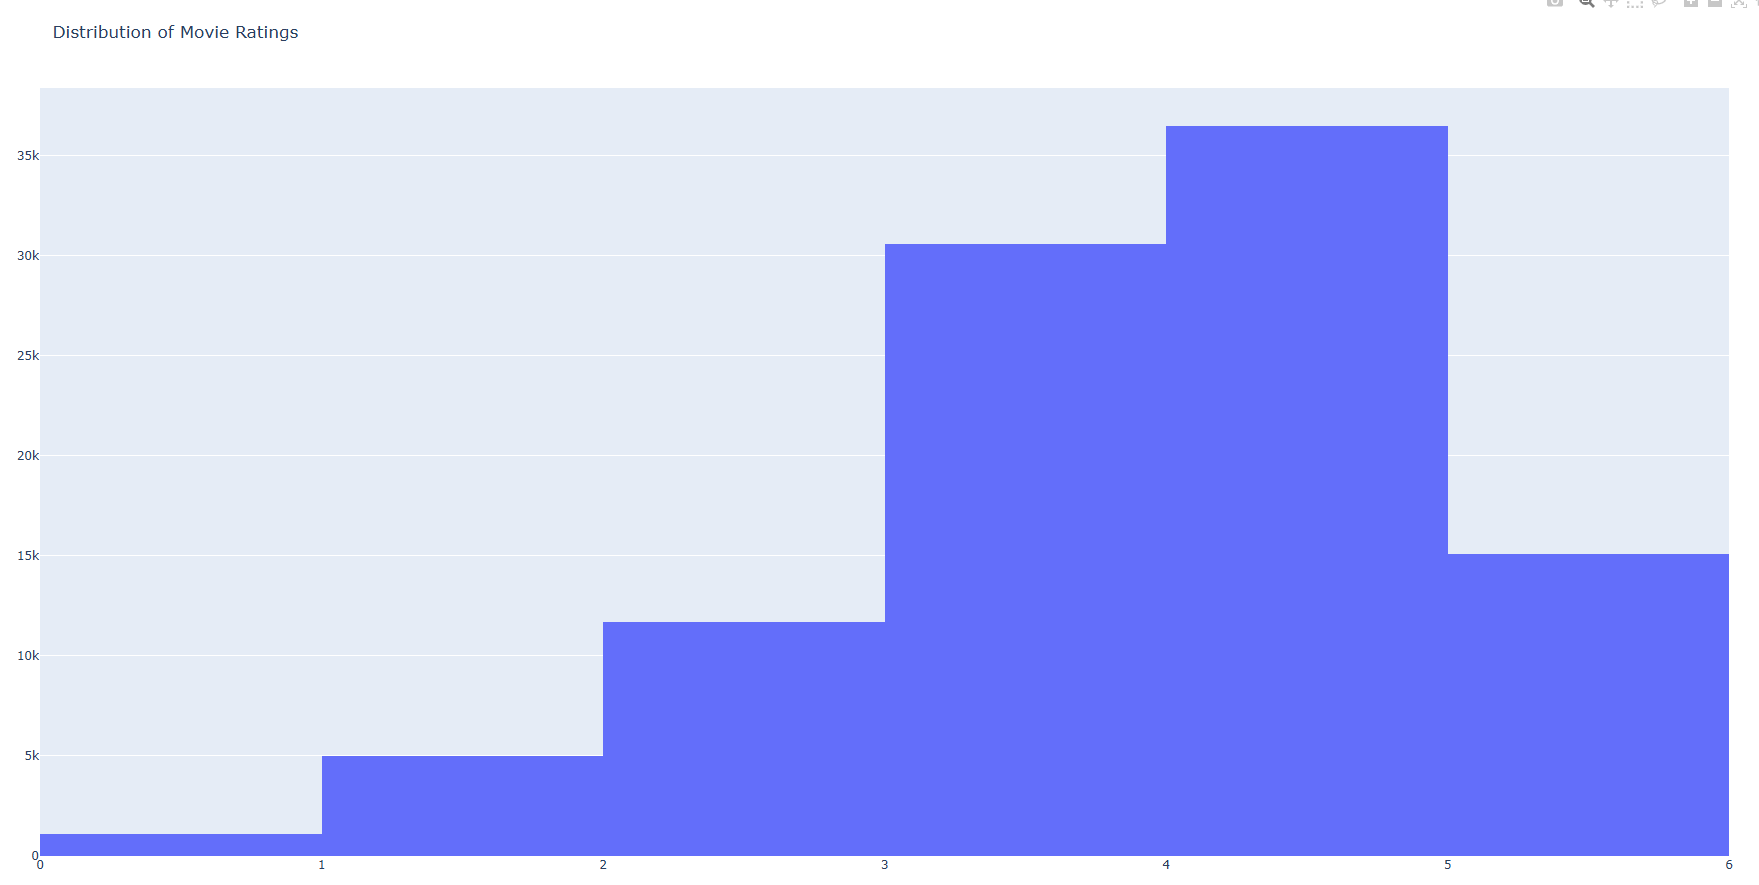

### Popularity-Based Movie Recommendation

A simple popularity-based recommendation system is implemented using the following approach:

- A function `recommend_popular(movies_df, top_n=10)` is defined to recommend movies based on their popularity.
- A copy of the relevant columns (`title`, `vote_average`, and `vote_count`) is extracted from the dataset.
- A **popularity metric** is computed by multiplying the **vote average** by the **vote count**, ensuring that highly-rated movies with more votes are prioritized.
- The movies are sorted in descending order based on this popularity metric.
- The top `n` most popular movies (defaulting to 10) are returned as recommendations.

In [19]:
def recommend_popular(movies_df, top_n=10):
    pop_ordered_movies = movies_df[["title", "vote_average", "vote_count"]].copy()

    pop_ordered_movies["popularity_metric"] = pop_ordered_movies["vote_average"] * pop_ordered_movies["vote_count"]

    pop_ordered_movies = pop_ordered_movies.sort_values("popularity_metric", ascending=False)
    
    return pop_ordered_movies[["title", "vote_average", "vote_count"]].head(top_n)


pop_recs = recommend_popular(movies_df, top_n=10)

In [21]:
def draw_pop_recs(pop_recs):
    pop_colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

    table_pop = pop_recs.copy()
    table_pop["vote_count"] = table_pop["vote_count"].apply(lambda x: int(x))
    table_pop.columns = ["Title", "Rating", "Users Voted"]

    fig =  ff.create_table(table_pop, colorscale=pop_colorscale)

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14

    fig.show(renderer="browser")

draw_pop_recs(pop_recs)

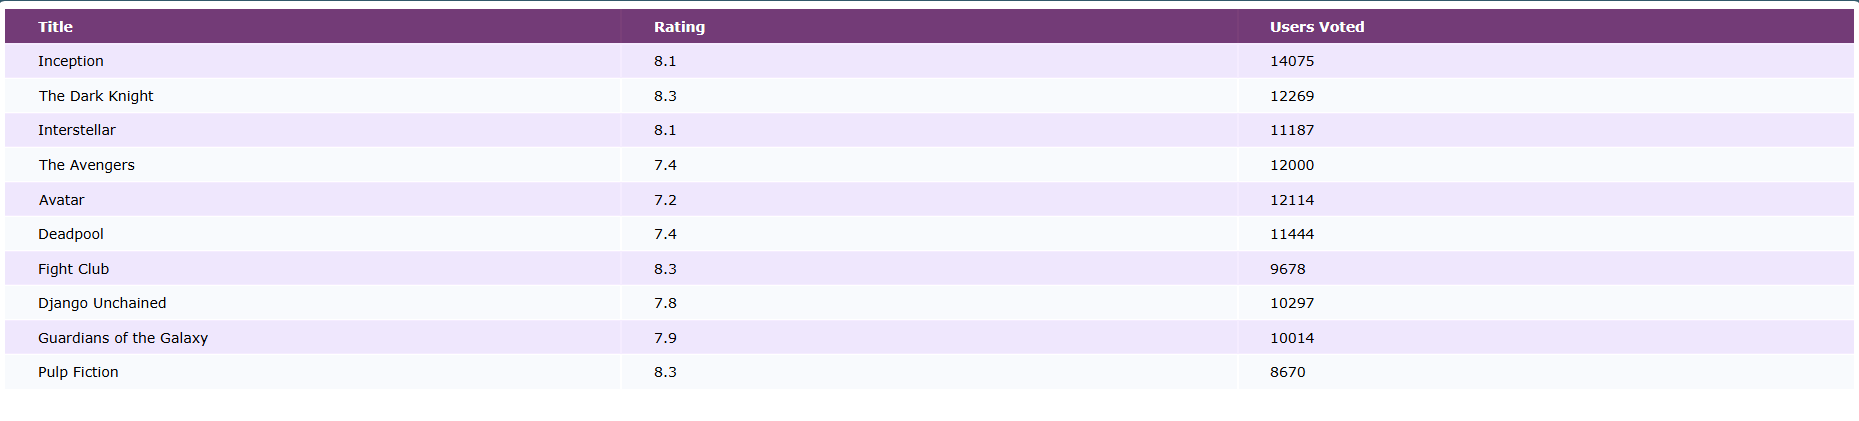

### Collaborative Filtering for Movie Recommendations

A **collaborative filtering approach** is implemented using **Singular Value Decomposition (SVD)** to generate movie recommendations based on user preferences. The following steps are carried out:

- A **Reader object** is instantiated with a rating scale ranging from **0.5 to 5.0**, defining the acceptable range for user ratings.
- A **Surprise Dataset object** is created by loading user-movie rating data from the `ratings_small_df` DataFrame.
- The dataset is split into **training (80%)** and **testing (20%)** sets using `train_test_split()`, ensuring reproducibility with a fixed random state.
- An **SVD model** is initialized with **50 latent factors** and a regularization parameter of **0.02** to balance generalization and overfitting.
- The **SVD model** is trained using the training set.
- **Cross-validation** is performed with **5 folds**, evaluating the model's performance based on **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)** to measure prediction accuracy.

In [27]:
rating_reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings_small_df[["userId", "movieId", "rating"]], rating_reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=50, reg_all=0.02, random_state=42)

svd_model.fit(trainset)

cv_results = cross_validate(svd_model, data, measures=["RMSE", "MAE"], cv=5)

NameError: name 'Reader' is not defined

In [10]:
def plot_cv_results(cv_results):
    df_cv = pd.DataFrame(cv_results)

    rmse_scores = df_cv["test_rmse"]
    mae_scores = df_cv["test_mae"]
    folds = list(range(1, len(rmse_scores) + 1))

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=folds, y=rmse_scores, mode='lines+markers', name="RMSE",
        line=dict(width=2, color='blue'),
        marker=dict(size=8, symbol="circle")
    ))

    fig.add_trace(go.Scatter(
        x=folds, y=mae_scores, mode='lines+markers', name="MAE",
        line=dict(width=2, color='red', dash="dash"),
        marker=dict(size=8, symbol="square")
    ))

    fig.update_layout(
        title="Cross-Validation Results: RMSE & MAE per Fold",
        xaxis_title="Cross-Validation Fold",
        yaxis_title="Error Score",
        xaxis=dict(tickmode="linear", dtick=1),
        template="plotly_white",
        legend=dict(x=0, y=1, bgcolor="rgba(255,255,255,0.5)")
    )

    fig.show()

plot_cv_results(cv_results)

### Mapping Movie IDs to Titles

To facilitate the identification of movies by their titles, the following preprocessing steps are applied:

- A helper function, `to_int(x)`, is defined to safely convert values to integers. If conversion fails, **NaN** is returned.
- A subset of the `links_small_df` DataFrame, containing `movieId` and `tmdbId`, is extracted and stored in `mid_to_title`.
- The `tmdbId` column is processed using the `to_int()` function to ensure all values are properly formatted as integers.
- Column names are renamed from `tmdbId` to `id` for consistency with the `movies_df` DataFrame.
- A **merge operation** is performed with `movies_df`, linking `id` values to movie `titles`, creating a mapping between **movieId** and **title** for easier reference in recommendation tasks.

In [11]:
def to_int(x):
    try:
        return int(x)
    except:
        return np.nan
    
mid_to_title = links_small_df[['movieId', 'tmdbId']].copy()
mid_to_title['tmdbId'] = mid_to_title['tmdbId'].apply(to_int)
mid_to_title.columns = ['movieId', 'id']
mid_to_title = mid_to_title.merge(movies_df[['title', 'id']], on='id')

### Collaborative Filtering Implementation

A **collaborative filtering recommendation function** is implemented using the trained **SVD model** to generate personalized movie recommendations for a given user:

- The function `recommend_cf(user_id, svd_model, mid_to_title, top_n=10)` is defined to predict the top **n** recommended movies for a specified user.
- All unique movie IDs from the `ratings_small_df` dataset are retrieved.
- Movies that have already been rated by the user are identified and excluded from the recommendation process.
- Predictions for unrated movies are generated using the **SVD model**, estimating the user's rating for each unseen movie.
- The predicted ratings are sorted in descending order, selecting the top **n** recommendations.
- The **movie titles** corresponding to the top-rated predictions are retrieved from the `mid_to_title` mapping.
- The recommendations are stored in a DataFrame, `cf_recs`, containing the **movie title** and its **predicted rating**.

This function provides personalized recommendations by leveraging collaborative filtering techniques to predict movies a user is likely to enjoy.

In [13]:
def recommend_cf(user_id, svd_model, mid_to_title, top_n=10):

    all_movie_ids = ratings_small_df["movieId"].unique()

    user_rated = ratings_small_df[ratings_small_df["userId"] == user_id]["movieId"].unique()
    
    predictions = []
    for mid in all_movie_ids:
        if mid not in user_rated:
            pred = svd_model.predict(user_id, mid)
            predictions.append((mid, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_predictions = predictions[:top_n]

    results = []
    for mid, rating_est in top_predictions:
        title = mid_to_title.loc[mid]["title"]
        
        results.append((title, rating_est))
    
    cf_recs = pd.DataFrame(results, columns=["title", "est_rating"])

    return cf_recs

In [14]:
user_id = 42
cf_recs = recommend_cf(user_id, svd_model, mid_to_title, top_n=10)

def draw_cf_recs(cf_recs):
    cf_colorscale = [[0, '#00274d'], [0.25, '#6699cc'], [1, '#ffffff']]

    table_cf = cf_recs.copy()
    table_cf["est_rating"] = table_cf["est_rating"].apply(lambda x: f"{float(x):.2f}")
    table_cf.columns = ["Title", "Estimated Rating"]

    fig =  ff.create_table(table_cf, colorscale=cf_colorscale)

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14

    fig.show()

draw_cf_recs(cf_recs)

In [15]:
def cf_recommendation_heatmap(df_recs):
    z = df_recs[["est_rating"]].values
    x_labels = ["Predicted Rating"]
    y_labels = df_recs["title"].astype(str).tolist()

    fig = ff.create_annotated_heatmap(
        z=z,
        x=x_labels,
        y=y_labels,
        colorscale="Blues",
        showscale=True
    )
    fig.update_layout(title="Collaborative Filtering Recommendations Heatmap")
    fig.show()


cf_recommendation_heatmap(cf_recs)

### Content-Based Filtering for Movie Recommendations

A **content-based filtering approach** is implemented using **TF-IDF (Term Frequency-Inverse Document Frequency)** and **cosine similarity** to recommend movies based on their textual features:

- A **TF-IDF vectorizer** is instantiated with **English stop words** removed to focus on meaningful terms.
- A **TF-IDF matrix** is generated by applying the vectorizer to the **"soup"** column, which contains a combined textual representation of a movie’s key attributes (director, cast, genres, and keywords).
- The **TF-IDF matrix** is converted into a **sparse matrix format** to optimize memory usage.
- **Cosine similarity** is computed between all movie vectors to measure their similarity in feature space.
- A **title-to-index mapping** is created, storing lowercase movie titles as the index and their corresponding DataFrame indices as values. This mapping allows quick lookup of a movie’s index based on its title.

This setup enables the retrieval of similar movies by comparing their feature-based representations using cosine similarity.

In [16]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies_df["soup"].fillna(""))

tfidf_sparse = csr_matrix(tfidf_matrix)

cosine_sim_sparse = cosine_similarity(tfidf_sparse, dense_output=False)

title_to_index = pd.Series(movies_df.index, index=movies_df["title"].fillna("").str.lower()).drop_duplicates()

In [17]:
def plot_cosine_similarity_heatmap(movie_titles, cosine_sim_sparse, title_to_index):
    
    movie_indices = [title_to_index.get(title.lower(), None) for title in movie_titles]

    valid_movies = [(title, idx) for title, idx in zip(movie_titles, movie_indices) if isinstance(idx, (int, np.integer))]
    
    filtered_titles, filtered_indices = zip(*valid_movies)
    filtered_indices = list(filtered_indices)

    similarity_matrix = cosine_sim_sparse[filtered_indices, :][:, filtered_indices].toarray()

    annotations = [[f"{val:.3f}" for val in row] for row in similarity_matrix]
    
    fig = ff.create_annotated_heatmap(
        z=similarity_matrix,
        x=filtered_titles,
        y=filtered_titles,
        colorscale="Oranges",
        showscale=True,
        annotation_text=annotations
    )
    
    fig.update_layout(
        title={
        "text": "Movie Similarity Heatmap (Cosine Similarity)",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "right",
        "yanchor": "top"
        },
        xaxis=dict(title="Movie"),
        yaxis=dict(title="Movie"),
    )
    
    fig.show()


selected_movies = ["Captain America: Civil War", 
                   "Avengers: Age of Ultron",
                   "Ant-Man", 
                   "The Avengers", 
                   "Iron Man 2", 
                   "Captain America: The Winter Soldier", 
                   "Thor: The Dark World", 
                   "Doctor Strange"]

plot_cosine_similarity_heatmap(selected_movies, cosine_sim_sparse, title_to_index)

### Content-Based Movie Recommendation Function

A **content-based filtering recommendation function** is implemented to suggest movies similar to a given title using **cosine similarity**:

- The function `recommend_cb(title, movies_df, title_to_index, cosine_sim, top_n=10)` is defined to retrieve the top **n** most similar movies based on textual features.
- The input **title** is converted to lowercase to ensure consistency with the `title_to_index` mapping.
- The corresponding **index** of the movie is retrieved from `title_to_index`.
- The **cosine similarity scores** of the given movie with all other movies are extracted and converted to a **flattened array**.
- The similarity scores are sorted in descending order, selecting the **top n most similar movies**, excluding the movie itself.
- The recommended movies are extracted from `movies_df`, including their **titles** and **similarity scores**.
- The final recommendations are returned as a DataFrame containing the **title** and **similarity score**, indicating how closely each movie matches the input title.

This function provides content-based recommendations by analyzing the similarity of movies based on their textual attributes.

In [19]:
def recommend_cb(title, movies_df, title_to_index, cosine_sim, top_n=10):
    title_lower = title.lower()

    idx = title_to_index[title_lower]

    similarity_scores = cosine_sim[idx].toarray().flatten()

    similar_movies = sorted(enumerate(similarity_scores), key=lambda x: x[1], reverse=True)[1: top_n+1]

    recommended_movies = movies_df.iloc[[idx for idx, _ in similar_movies]][["title"]].copy()

    recommended_movies["similarity_score"] = [similarity_score for _, similarity_score in similar_movies]

    return recommended_movies[["title", "similarity_score"]]

In [20]:
fav_movie_title = "Gone Girl"
cb_recs = recommend_cb(fav_movie_title, movies_df, title_to_index, cosine_sim_sparse, top_n=10)

def draw_cb_recs(cb_recs):
    cb_colorscale = [[0, '#004d00'], [0.5, '#66cc66'], [1, '#ffffff']]

    table_cb = cb_recs.copy()

    table_cb["similarity_score"] = table_cb["similarity_score"].apply(lambda x: f"{x: .3f}")
    
    table_cb.columns = ["Title", "Similarity Score"]

    fig =  ff.create_table(table_cb, colorscale=cb_colorscale)

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14

    fig.show()

draw_cb_recs(cb_recs)

In [21]:
def plot_cb_popularity_vs_similarity(df_recs, movies_df):
    df_merged = df_recs.merge(movies_df[["title", "popularity"]], on="title", how="left")

    df_merged = df_merged.assign(popularity=df_merged["popularity"].fillna(0))

    fig = px.scatter(
        df_merged,
        x="popularity",
        y="similarity_score",
        size="similarity_score",
        color="similarity_score",
        hover_name="title",
        title="Content Similarity vs. Movie Popularity",
        labels={"popularity": "Movie Popularity", "similarity_score": "Content Similarity Score"},
    )
    
    fig.show()

plot_cb_popularity_vs_similarity(cb_recs, movies_df)

### Hybrid Movie Recommendation System

A **hybrid recommendation function** is implemented by combining **collaborative filtering (CF)** and **content-based filtering (CB)** to generate personalized recommendations:

- The function `recommend_hybrid(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim, top_n=10)` is defined to blend CF and CB recommendations.
- **Collaborative filtering recommendations** are generated using `recommend_cf()`, predicting movies based on user preferences.
- **Content-based recommendations** are generated using `recommend_cb()`, retrieving movies similar to the user's favorite title.
- The estimated ratings from CF (`est_rating`) and similarity scores from CB (`similarity_score`) are **normalized** using a `scaler()` function.
- The CF and CB recommendations are merged based on the movie title using an **outer join**, ensuring that movies recommended by either method are included.
- Missing values in the **CF score, CB score, and estimated rating** are converted to zero to avoid errors.
- The **final hybrid score** is computed as a weighted sum of the CF and CB scores:
  - **Collaborative filtering weight** = **0.6** (higher emphasis on user preferences)
  - **Content-based filtering weight** = **0.4** (lower emphasis on similarity)
- The resulting recommendations are **sorted in descending order** based on the hybrid score.
- The function returns a DataFrame containing the **movie title**, **estimated rating**, **CF score**, **CB score**, and the final **hybrid score**, selecting the top **n** movies.

This hybrid approach enhances recommendation quality by leveraging both **user-based preferences** and **movie similarity**, providing a well-balanced list of personalized movie suggestions.

In [24]:
def scaler(column):
    max_est = column.max()
    min_est = column.min()

    return (column - min_est) / (max_est - min_est + 1e-9)

In [25]:
def recommend_hybrid(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim, top_n=10):
    cf_df = recommend_cf(user_id, svd_model, mid_to_title, top_n=top_n)

    cb_df = recommend_cb(favorite_title, movies_df, title_to_index, cosine_sim, top_n=top_n)

    cf_df["cf_score"] = scaler(cf_df["est_rating"])

    cb_df["cb_score"] = scaler(cb_df["similarity_score"])

    combined = pd.merge(cf_df, cb_df, on="title", how="outer", suffixes=("_cf", "_cb"))

    for col in ["est_rating", "cf_score", "cb_score"]:
        combined[col] = pd.to_numeric(combined[col], errors="coerce").fillna(0)

    cf_weight = 0.6
    cb_weight = 0.4
    
    combined["hybrid_score"] = (cf_weight * combined["cf_score"]) + (cb_weight * combined["cb_score"])
    
    combined = combined.sort_values("hybrid_score", ascending=False)

    return combined[["title", "est_rating", "cf_score", "cb_score", "hybrid_score"]].head(top_n)

In [26]:
user_id = 42

hybrid_recs = recommend_hybrid(user_id, fav_movie_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim_sparse, top_n=10)

def draw_hybrid_recs(hybrid_recs):
    hybrid_colorscale = [[0, '#2b1d0e'], [0.5, '#d4af37'], [1, '#ffffff']]

    table_hybrid = hybrid_recs[["title", "est_rating", "cf_score", "cb_score", "hybrid_score"]].copy()

    for col in table_hybrid.columns[1:]:
        table_hybrid[col] = table_hybrid[col].apply(lambda x: f"{x:.3f}")

    table_hybrid.columns = ["Title", "Estimated Rating", "CF Score", "CB Score", "Hybrid Score"]

    fig =  ff.create_table(table_hybrid, colorscale=hybrid_colorscale)

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14

    fig.show()

draw_hybrid_recs(hybrid_recs)

In [27]:
def plot_hybrid_recs(df_recs):
    fig = px.bar(
        df_recs,
        x="title",
        y="hybrid_score",
        color="hybrid_score",
        text="hybrid_score",
        title="Top Movie Recommendations (Hybrid Score)",
        labels={"title": "Movie Title", "hybrid_score": "Hybrid Score"},
    )

    fig.update_layout(xaxis={"categoryorder":"total descending"})
    fig.show()


plot_hybrid_recs(hybrid_recs)

In [28]:
def heatmap_cf_cb(df_recs):
    z = df_recs[["cf_score", "cb_score", "hybrid_score"]].values
    x_labels = ["CF Score", "CB Score", "Hybrid Score"]
    y_labels = df_recs["title"].astype(str).tolist()

    fig = ff.create_annotated_heatmap(
        z=z,
        x=x_labels,
        y=y_labels,
        colorscale="Blues",
        showscale=True
    )

    fig.update_layout(title="CF vs. CB Contribution to Hybrid Score")
    fig.show()

heatmap_cf_cb(hybrid_recs)

In [29]:
def bubble_chart(df_recs):
    fig = px.scatter(
        df_recs,
        x="cf_score",
        y="cb_score",
        size="hybrid_score",
        color="hybrid_score",
        hover_name="title",
        title="Hybrid Score vs. CF and CB Contributions",
        labels={"cf_score": "CF Score", "cb_score": "CB Score"}
    )

    fig.show()

bubble_chart(hybrid_recs)

### Final Movie Recommendation Function: **Filmiye**

A **finalized recommendation system** is implemented through the function `filmiye()`, which determines the most suitable recommendation strategy based on the availability of user data:

- The function `filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim, top_n=10)` takes in a user's **ID** and **favorite movie title** to generate recommendations.
- The list of **all unique user IDs** is extracted from the dataset.
- A conditional check is performed:
  - If the **user is new** (i.e., their ID is not found in the dataset), **popularity-based recommendations** are generated using `recommend_popular()`, and the results are displayed using `draw_pop_recs()`.
  - If the **user** doesn't have a favorite title but has been actively engaging with other movies, **collaborative filtering-based recommendations** are generated using `recommend_cf()`, and the results are displayed using `draw_cf_recs()`.
  - If the **user exists in the dataset**, a **hybrid recommendation** is generated using `recommend_hybrid()`, combining collaborative and content-based filtering. The results are displayed using `draw_hybrid_recs()`.
  
This function ensures a dynamic recommendation system that adapts based on the user's history:
- **New users** receive **popularity-based** recommendations due to a lack of historical ratings.
- **Existing users** receive **personalized recommendations** through a hybrid approach that blends **user preferences** and **content similarity**.

By incorporating multiple recommendation strategies, `filmiye()` ensures relevant and engaging movie suggestions tailored to different user types.

In [44]:
def filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim, top_n=10):
    all_user_ids = ratings_small_df["userId"].unique()

    if user_id not in all_user_ids and favorite_title == "":
        draw_pop_recs(recommend_popular(movies_df, top_n=10))

    elif user_id not in all_user_ids and favorite_title != "":
        draw_cb_recs(recommend_cb(favorite_title, movies_df, title_to_index, cosine_sim, top_n))

    elif user_id in all_user_ids and favorite_title == "":
        draw_cf_recs(recommend_cf(user_id, svd_model, mid_to_title, top_n=10))
    
    else:
        draw_hybrid_recs(recommend_hybrid(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim, top_n))

In [45]:
user_id = 12
favorite_title = "Interstellar"

filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim_sparse)

In [46]:
user_id = -88
favorite_title = "Deadpool"

filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim_sparse)

In [47]:
user_id = 12
favorite_title = ""

filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim_sparse)

In [48]:
user_id = -12
favorite_title = ""

filmiye(user_id, favorite_title, movies_df, svd_model, mid_to_title, title_to_index, cosine_sim_sparse)